# Build simulation environment for Contextual Bandits

> We don’t actually have to implement the Environment in TF-Agents because during training the data is read offline from logs, and during inference, the policy is served in the actual production environment as a SavedModel on a Vertex endpoint. It may be useful to have an environment for running simulation experiments though.

## Load notebook config

* use the prefix defined in `00-env-setup`

In [1]:
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


In [2]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"
DATA_PATH_KFP_DEMO       = "gs://rec-bandits-v2-hybrid-vertex-bucket/data/kfp_demo_data/u.data"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NA

## imports

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [4]:
import functools
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

from tqdm import tqdm

# logging
# logging
import logging
logging.disable(logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
# from tf_agents.agents import TFAgent

from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.bandits.agents import neural_epsilon_greedy_agent
from tf_agents.bandits.agents import neural_linucb_agent
from tf_agents.bandits.networks import global_and_arm_feature_network
from tf_agents.bandits.policies import policy_utilities

from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.trajectories import trajectory

# GPU
from numba import cuda 
import gc

import sys
sys.path.append("..")

# this repo
from src.per_arm_rl import data_utils
from src.per_arm_rl import data_config
from src.per_arm_rl import train_utils as train_utils

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [7]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

In [8]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

### Read TF Records (for testing)

In [9]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [10]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(f"{BUCKET_NAME}", prefix=f'{DATA_GCS_PREFIX}/{SPLIT}'):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://rec-bandits-v2-hybrid-vertex-bucket/data/train/ml-ratings-100k-train.tfrecord']

In [11]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils.parse_tfrecord)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'bucketized_user_age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([35.], dtype=float32)>,
 'movie_genres': <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[7]])>,
 'movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'898'], dtype=object)>,
 'timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([885409515])>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'681'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'marketing'], dtype=object)>,
 'user_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>}


### get vocab

In [12]:
GENERATE_VOCABS = False

print(f"GENERATE_VOCABS: {GENERATE_VOCABS}")

GENERATE_VOCABS: False


In [13]:
if not GENERATE_VOCABS:

    EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{VOCAB_SUBDIR}/{VOCAB_FILENAME}'
    print(f"Downloading vocab...")
    
    os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
    print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

    filehandler = open(VOCAB_FILENAME, 'rb')
    vocab_dict = pkl.load(filehandler)
    filehandler.close()
    
    for key in vocab_dict.keys():
        pprint(key)

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/vocabs/vocab_dict.pkl

'movie_id'
'user_id'
'user_occupation_text'
'movie_genres'
'bucketized_user_age'
'max_timestamp'
'min_timestamp'
'timestamp_buckets'


# Global & Per-Arm feature embedding models 

In [14]:
NUM_OOV_BUCKETS        = 1
GLOBAL_EMBEDDING_SIZE  = 16
MV_EMBEDDING_SIZE      = 32 #32

In [15]:
# test emb models
for i in range(1):
    
    iterator = iter(train_dataset.batch(1))
    data = next(iterator)

# data

In [16]:
from src.perarm_features import emb_features as emb_features

embs = emb_features.EmbeddingModel(
    vocab_dict = vocab_dict,
    num_oov_buckets = NUM_OOV_BUCKETS,
    global_emb_size = GLOBAL_EMBEDDING_SIZE,
    mv_emb_size = MV_EMBEDDING_SIZE,
)

embs

In [17]:
test_globals = embs._get_global_context_features(data)

GLOBAL_DIM = test_globals.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"GLOBAL_DIM: {GLOBAL_DIM}")

test_globals

GLOBAL_DIM: 64


array([[-4.48094010e-02,  5.56134060e-03,  1.13763660e-03,
        -3.64574902e-02, -1.35886781e-02,  2.05127709e-02,
        -2.95544788e-03,  6.75355271e-03,  1.97401382e-02,
         4.03256454e-02,  2.50823013e-02, -1.12961158e-02,
        -1.00527294e-02, -5.90469688e-03, -1.74714327e-02,
         9.45359468e-03, -3.93234603e-02, -3.47077474e-02,
         1.29960440e-02, -4.20147069e-02, -4.14742120e-02,
         1.81941278e-02,  1.19779222e-02, -2.72599459e-02,
        -2.72291545e-02,  3.27972434e-02, -2.41138469e-02,
        -4.54033278e-02, -2.01030374e-02,  1.50305890e-02,
         4.82046865e-02,  1.95825361e-02, -3.31553593e-02,
         3.11768986e-02, -1.24112740e-02, -1.24300495e-02,
         5.93122095e-03, -3.51259485e-02,  4.86529507e-02,
        -2.09562071e-02, -3.62384543e-02, -3.13106664e-02,
        -4.67677042e-03,  6.80928305e-03, -4.94968556e-02,
         4.38060202e-02, -8.10027122e-05, -4.65124026e-02,
        -9.51969624e-03,  1.27804540e-02, -1.02393702e-0

In [18]:
test_arms = embs._get_per_arm_features(data)

PER_ARM_DIM = test_arms.shape[1]            
# shape checks out at batch_dim, nactions, arm feats
print(f"PER_ARM_DIM: {PER_ARM_DIM}")

test_arms

PER_ARM_DIM: 64


array([[-4.32674289e-02,  1.42864473e-02, -4.37188260e-02,
        -3.25715914e-02, -2.34106071e-02, -2.12632306e-02,
        -2.68472787e-02, -1.24076754e-03, -3.48634720e-02,
        -1.93394907e-02, -8.64043832e-05, -1.61124691e-02,
        -3.91933210e-02,  2.67719142e-02,  5.42424619e-04,
         4.94989865e-02, -9.50461626e-03,  2.47127078e-02,
         3.42675708e-02,  2.59853266e-02,  8.27262551e-03,
        -1.05688348e-02,  3.42545547e-02, -5.71421534e-03,
        -4.90558036e-02,  3.78474481e-02, -3.92991304e-03,
         5.71980327e-03, -8.24216753e-03, -2.00525671e-03,
         4.68511321e-02, -7.99720362e-03, -1.37356669e-03,
        -2.31453180e-02,  1.23472437e-02, -1.52695887e-02,
         4.65050973e-02, -3.11988238e-02,  1.45116933e-02,
        -6.58097118e-03, -1.77757740e-02, -8.04501772e-03,
         3.57102603e-04,  2.51528881e-02, -4.78373878e-02,
        -2.94797067e-02, -1.96158532e-02,  1.02541335e-02,
        -3.87904048e-02, -2.66781207e-02, -3.49984542e-0

In [19]:
test_arms.shape

(1, 64)

# Per-arm environment

In this example we will use the [StationaryStochasticPerArmPyEnvironment](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environments/stationary_stochastic_per_arm_py_environment.py) environment to simulate offline training data for training a contextual bandit with **per-arm features**

To initialize the per-arm environment, one has to define functions that generate

* *global and per-arm features*: These functions have no input parameters and generate a single (global or per-arm) feature vector when called.

* *rewards*: This function takes as parameter the concatenation of a global and a per-arm feature vector, and generates a reward. Basically this is the function that the agent will have to "guess". 

It is worth noting here that in the per-arm case the reward function is identical for every arm. This is a fundamental difference from the classic bandit case, where the agent has to estimate reward functions for each arm independently.

## Sampling and reward functions

The preproccesing layers will ultimately feed the two sampling functions described below. These sampling functions will be used to create [trajectories](https://github.com/tensorflow/agents/blob/master/tf_agents/trajectories/trajectory.py#L36) (i.e., the training examples for our model)

`global_context_sampling_fn`: 
* A function that outputs a random 1d array or list of ints or floats
* This output is the global context. Its shape and type must be consistent across calls.

`arm_context_sampling_fn`: 
* A function that outputs a random 1 array or list of ints or floats (same type as the output of `global_context_sampling_fn`). 
* This output is the per-arm context. Its shape must be consistent across calls.

`reward_fn`: function takes the concatenation of a global and a per-arm feature, and outputs a possibly random reward.

In [20]:
BATCH_SIZE      = 128
EVAL_BATCH_SIZE = 1
NUM_ACTIONS     = 2

### sampling global context

In [21]:
def example_global_context_sampling_fn():
    # return np.random.randint(0, 10, [2])  # 2-dimensional global features.
    return np.random.randint(-1, 1, [GLOBAL_DIM]).astype(np.float32)

example_global_context_sampling_fn()

array([ 0., -1., -1., -1.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
       -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1., -1.,
        0.,  0., -1., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
       -1.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,
        0., -1.,  0., -1., -1.,  0., -1.,  0.,  0.,  0.,  0., -1.],
      dtype=float32)

In [22]:
global_iterator = iter(train_dataset.batch(1).repeat())

def global_context_sampling_fn():
    
    data = next(global_iterator)
    
    return embs._get_global_context_features(data)[0]

In [23]:
test_global_sampling = global_context_sampling_fn()
print(f"shape: {test_global_sampling.shape}")

test_global_sampling

shape: (64,)


array([-4.48094010e-02,  5.56134060e-03,  1.13763660e-03, -3.64574902e-02,
       -1.35886781e-02,  2.05127709e-02, -2.95544788e-03,  6.75355271e-03,
        1.97401382e-02,  4.03256454e-02,  2.50823013e-02, -1.12961158e-02,
       -1.00527294e-02, -5.90469688e-03, -1.74714327e-02,  9.45359468e-03,
       -3.93234603e-02, -3.47077474e-02,  1.29960440e-02, -4.20147069e-02,
       -4.14742120e-02,  1.81941278e-02,  1.19779222e-02, -2.72599459e-02,
       -2.72291545e-02,  3.27972434e-02, -2.41138469e-02, -4.54033278e-02,
       -2.01030374e-02,  1.50305890e-02,  4.82046865e-02,  1.95825361e-02,
       -3.31553593e-02,  3.11768986e-02, -1.24112740e-02, -1.24300495e-02,
        5.93122095e-03, -3.51259485e-02,  4.86529507e-02, -2.09562071e-02,
       -3.62384543e-02, -3.13106664e-02, -4.67677042e-03,  6.80928305e-03,
       -4.94968556e-02,  4.38060202e-02, -8.10027122e-05, -4.65124026e-02,
       -9.51969624e-03,  1.27804540e-02, -1.02393702e-03,  3.62861790e-02,
        1.03485100e-02, -

### sampling arm context

In [24]:
def example_arm_context_sampling_fn():
    # return np.random.randint(-3, 4, [3])  # 3-dimensional arm features.
    return np.random.randint(-2, 3, [PER_ARM_DIM]).astype(np.float32)

example_arm_context_sampling_fn()

array([-1.,  1.,  1., -1., -2.,  0., -2.,  1., -2., -1.,  0.,  1., -1.,
       -2.,  1.,  1.,  0., -1.,  1.,  1., -2.,  2.,  1., -1.,  1.,  1.,
        0.,  1.,  0.,  0.,  1.,  0., -2., -1., -2., -2.,  1., -1.,  0.,
        2., -2.,  2.,  0.,  0., -2., -2.,  0.,  1., -1., -2., -2.,  2.,
        1.,  2., -2.,  1., -2.,  1.,  2.,  1.,  2., -1.,  1., -2.],
      dtype=float32)

In [25]:
arm_iterator = iter(train_dataset.batch(1).repeat())
# arm_iterator = iter(train_dataset.repeat())

def arm_context_sampling_fn():
    
    data = next(arm_iterator)
    
    return embs._get_per_arm_features(data)[0]

In [26]:
test_arm_sampling = arm_context_sampling_fn()
print(f"shape: {test_arm_sampling.shape}")

test_arm_sampling

shape: (64,)


array([-4.32674289e-02,  1.42864473e-02, -4.37188260e-02, -3.25715914e-02,
       -2.34106071e-02, -2.12632306e-02, -2.68472787e-02, -1.24076754e-03,
       -3.48634720e-02, -1.93394907e-02, -8.64043832e-05, -1.61124691e-02,
       -3.91933210e-02,  2.67719142e-02,  5.42424619e-04,  4.94989865e-02,
       -9.50461626e-03,  2.47127078e-02,  3.42675708e-02,  2.59853266e-02,
        8.27262551e-03, -1.05688348e-02,  3.42545547e-02, -5.71421534e-03,
       -4.90558036e-02,  3.78474481e-02, -3.92991304e-03,  5.71980327e-03,
       -8.24216753e-03, -2.00525671e-03,  4.68511321e-02, -7.99720362e-03,
       -1.37356669e-03, -2.31453180e-02,  1.23472437e-02, -1.52695887e-02,
        4.65050973e-02, -3.11988238e-02,  1.45116933e-02, -6.58097118e-03,
       -1.77757740e-02, -8.04501772e-03,  3.57102603e-04,  2.51528881e-02,
       -4.78373878e-02, -2.94797067e-02, -1.96158532e-02,  1.02541335e-02,
       -3.87904048e-02, -2.66781207e-02, -3.49984542e-02,  1.12209544e-02,
        4.53852676e-02,  

### reward function 

> compute the dot product between global user context features and arm context features

In this environment, the reward function will take as input the concatenation of the global and arm features generated from the provided sampling functions. See it used in the environment's `_apply_action()` function [here](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/environments/stationary_stochastic_per_arm_py_environment.py#L170C18-L170C28)

```python
feat_concat = np.concatenate((test_global_sampling, test_arm_sampling))
reward = np.dot(feat_concat[:GLOBAL_DIM], feat_concat[PER_ARM_DIM:])
```

In [27]:
test_global_sampling #[0]

array([-4.48094010e-02,  5.56134060e-03,  1.13763660e-03, -3.64574902e-02,
       -1.35886781e-02,  2.05127709e-02, -2.95544788e-03,  6.75355271e-03,
        1.97401382e-02,  4.03256454e-02,  2.50823013e-02, -1.12961158e-02,
       -1.00527294e-02, -5.90469688e-03, -1.74714327e-02,  9.45359468e-03,
       -3.93234603e-02, -3.47077474e-02,  1.29960440e-02, -4.20147069e-02,
       -4.14742120e-02,  1.81941278e-02,  1.19779222e-02, -2.72599459e-02,
       -2.72291545e-02,  3.27972434e-02, -2.41138469e-02, -4.54033278e-02,
       -2.01030374e-02,  1.50305890e-02,  4.82046865e-02,  1.95825361e-02,
       -3.31553593e-02,  3.11768986e-02, -1.24112740e-02, -1.24300495e-02,
        5.93122095e-03, -3.51259485e-02,  4.86529507e-02, -2.09562071e-02,
       -3.62384543e-02, -3.13106664e-02, -4.67677042e-03,  6.80928305e-03,
       -4.94968556e-02,  4.38060202e-02, -8.10027122e-05, -4.65124026e-02,
       -9.51969624e-03,  1.27804540e-02, -1.02393702e-03,  3.62861790e-02,
        1.03485100e-02, -

In [28]:
test_arm_sampling #[0]

array([-4.32674289e-02,  1.42864473e-02, -4.37188260e-02, -3.25715914e-02,
       -2.34106071e-02, -2.12632306e-02, -2.68472787e-02, -1.24076754e-03,
       -3.48634720e-02, -1.93394907e-02, -8.64043832e-05, -1.61124691e-02,
       -3.91933210e-02,  2.67719142e-02,  5.42424619e-04,  4.94989865e-02,
       -9.50461626e-03,  2.47127078e-02,  3.42675708e-02,  2.59853266e-02,
        8.27262551e-03, -1.05688348e-02,  3.42545547e-02, -5.71421534e-03,
       -4.90558036e-02,  3.78474481e-02, -3.92991304e-03,  5.71980327e-03,
       -8.24216753e-03, -2.00525671e-03,  4.68511321e-02, -7.99720362e-03,
       -1.37356669e-03, -2.31453180e-02,  1.23472437e-02, -1.52695887e-02,
        4.65050973e-02, -3.11988238e-02,  1.45116933e-02, -6.58097118e-03,
       -1.77757740e-02, -8.04501772e-03,  3.57102603e-04,  2.51528881e-02,
       -4.78373878e-02, -2.94797067e-02, -1.96158532e-02,  1.02541335e-02,
       -3.87904048e-02, -2.66781207e-02, -3.49984542e-02,  1.12209544e-02,
        4.53852676e-02,  

In [29]:
# def dot_reward_fn(x):
#     """
#     This function generates a reward from the 
#     concatenated global and per-arm observations.
#     """
#     _globals = x[:GLOBAL_DIM]
#     _arms = x[PER_ARM_DIM:]
    
#     return (1 - np.dot(_globals, _arms))

# # test reward function
# feat_concat = np.concatenate((test_global_sampling, test_arm_sampling))
# reward_fn = dot_reward_fn(feat_concat)

# reward_fn

In [30]:
# HIDDEN_PARAM = [0, 1, 2, 3, 4, 5, 6, 7, 8]
HIDDEN_PARAM = list(np.random.randint(0, 10, [GLOBAL_DIM + PER_ARM_DIM]))

class LinearNormalReward(object):
    def __init__(self, theta):
        self.theta = theta

    def __call__(self, x):
        mu = np.dot(x, self.theta)
        return np.random.normal(mu, 1)
    
reward_fn = LinearNormalReward(HIDDEN_PARAM)

In [31]:
# HIDDEN_PARAM

## Initialize environment

In [32]:
print(f"BATCH_SIZE      : {BATCH_SIZE}")
print(f"EVAL_BATCH_SIZE : {EVAL_BATCH_SIZE}")
print(f"NUM_ACTIONS     : {NUM_ACTIONS}")
print(f"GLOBAL_DIM      : {GLOBAL_DIM}")
print(f"PER_ARM_DIM     : {PER_ARM_DIM}")

BATCH_SIZE      : 128
EVAL_BATCH_SIZE : 1
NUM_ACTIONS     : 2
GLOBAL_DIM      : 64
PER_ARM_DIM     : 64


In [33]:
per_arm_py_env = p_a_env.StationaryStochasticPerArmPyEnvironment(
    global_context_sampling_fn=global_context_sampling_fn,
    arm_context_sampling_fn=arm_context_sampling_fn,
    max_num_actions=NUM_ACTIONS,
    reward_fn=reward_fn,
    batch_size=BATCH_SIZE
)
per_arm_tf_env = tf_py_environment.TFPyEnvironment(per_arm_py_env)

In [34]:
print('observation spec: ', per_arm_tf_env.observation_spec())
print('\nAn observation: ', per_arm_tf_env.reset().observation)

action = tf.zeros(BATCH_SIZE, dtype=tf.int32)
time_step = per_arm_tf_env.step(action)
print('\nRewards after taking an action: ', time_step.reward)

observation spec:  {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

An observation:  {'global': <tf.Tensor: shape=(128, 64), dtype=float32, numpy=
array([[-0.03628515, -0.03890603, -0.03459045, ..., -0.00254239,
         0.03685356, -0.01657288],
       [-0.04948723, -0.02553049, -0.04894139, ...,  0.01082891,
        -0.04859681, -0.00772994],
       [ 0.03936208, -0.02765383,  0.03570527, ..., -0.00577347,
         0.02283515, -0.00359394],
       ...,
       [ 0.02111211,  0.02780452,  0.04162115, ...,  0.03075692,
         0.00083244,  0.01437471],
       [-0.00115246, -0.01530515, -0.04842767, ...,  0.03805212,
        -0.01621739,  0.04664835],
       [ 0.0167228 , -0.03028063,  0.00263254, ...,  0.04051599,
         0.03765148, -0.00538802]], dtype=float32)>, 'per_arm': <tf.Tensor: shape=(128, 2, 64), dtype=float32, numpy=
array([[[ 0.01354567,  0.00322006,  0.03057537, ..., -0.04322981,
        

In [35]:
observation_spec = per_arm_tf_env.observation_spec()
observation_spec

{'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)}

In [36]:
time_step_spec = ts.time_step_spec(observation_spec)
time_step_spec

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(2, 64), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [37]:
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, 
    shape=(), 
    minimum=0, 
    maximum=NUM_ACTIONS - 1
)
action_spec

BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(1, dtype=int32))

## Define Agent Policy

### agent config

In [69]:
# ================================
# Agents
# ================================
AGENT_TYPE      = 'LinUCB' # 'LinUCB' | 'LinTS |, 'epsGreedy' | 'NeuralLinUCB'

# Parameters for linear agents (LinUCB and LinTS).
AGENT_ALPHA     = 0.1

# Parameters for neural agents (NeuralEpsGreedy and NerualLinUCB).
EPSILON         = 0.01
LR              = 0.05

# Parameters for NeuralLinUCB
ENCODING_DIM    = 1
EPS_PHASE_STEPS = 1000

# ================================
# Agent's Preprocess Network
# ================================
NETWORK_TYPE    = "dotproduct" # 'dotproduct' | 'dotproduct'

if AGENT_TYPE == 'NeuralLinUCB':
    NETWORK_TYPE = 'commontower'
    
GLOBAL_LAYERS   = [64, 32, 16] # beginning should be of size: GLOBAL_DIM
ARM_LAYERS      = [64, 32, 16] # beginning should be of size: PER_ARM_DIM
COMMON_LAYERS   = [16, 8]

HPARAMS = {  # TODO - streamline and consolidate
    "batch_size": BATCH_SIZE,
    "eval_batch_size" : EVAL_BATCH_SIZE,
    "num_actions": NUM_ACTIONS,
    "model_type": AGENT_TYPE,
    "network_type": NETWORK_TYPE,
    "global_layers": GLOBAL_LAYERS,
    "per_arm_layers": ARM_LAYERS,
    "common_layers": COMMON_LAYERS,
    "learning_rate": LR,
    "epsilon": EPSILON,
}
pprint(HPARAMS)

{'batch_size': 128,
 'common_layers': [16, 8],
 'epsilon': 0.01,
 'eval_batch_size': 1,
 'global_layers': [64, 32, 16],
 'learning_rate': 0.05,
 'model_type': 'LinUCB',
 'network_type': 'dotproduct',
 'num_actions': 2,
 'per_arm_layers': [64, 32, 16]}


In [70]:
from src.perarm_features import agent_factory as agent_factory

global_step = tf.compat.v1.train.get_or_create_global_step()

agent = agent_factory.PerArmAgentFactory._get_agent(
    agent_type = AGENT_TYPE,
    network_type = NETWORK_TYPE,
    time_step_spec = time_step_spec,
    action_spec = action_spec,
    observation_spec=observation_spec,
    global_layers = GLOBAL_LAYERS,
    arm_layers = ARM_LAYERS,
    common_layers = COMMON_LAYERS,
    agent_alpha = AGENT_ALPHA,
    learning_rate = LR,
    epsilon = EPSILON,
    train_step_counter = global_step,
    output_dim = ENCODING_DIM,
    eps_phase_steps = EPS_PHASE_STEPS,
    summarize_grads_and_vars = True,
    debug_summaries = True
)
      
agent.initialize()
print(f'agent: {agent.name}')

# if network:
#     print(f"Network: {network}")

if NETWORK_TYPE:
    print(f"Network: {NETWORK_TYPE}")

agent: linear_ucb_agent
Network: dotproduct


### The Flow of Training Data

look at the data specification in the agent. The training_data_spec attribute of the agent specifies what elements and structure the training data should have.

In [71]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(64,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(64,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


In [72]:
def _all_rewards(observation, hidden_param):
    """Outputs rewards for all actions, given an observation."""
    hidden_param = tf.cast(hidden_param, dtype=tf.float32)
    global_obs = observation[bandit_spec_utils.GLOBAL_FEATURE_KEY]
    per_arm_obs = observation[bandit_spec_utils.PER_ARM_FEATURE_KEY]
    num_actions = tf.shape(per_arm_obs)[1]
    tiled_global = tf.tile(
        tf.expand_dims(global_obs, axis=1), [1, num_actions, 1]
    )
    concatenated = tf.concat([tiled_global, per_arm_obs], axis=-1)
    rewards = tf.linalg.matvec(concatenated, hidden_param)
    return rewards

def optimal_reward(observation):
    """
    Outputs the maximum expected reward 
    for every element in the batch.
    """
    return tf.reduce_max(_all_rewards(observation, HIDDEN_PARAM), axis=1)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward)

In [73]:
def optimal_action(observation, hidden_param):
    
    return tf.argmax(
        _all_rewards(observation, hidden_param), axis=1, output_type=tf.int32
    )

optimal_action_fn = functools.partial(
    optimal_action, hidden_param=HIDDEN_PARAM
)

suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
    optimal_action_fn
)

# Training

## Simple train

In [74]:
num_iterations = 100 # @param
steps_per_loop = 1 # @param

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=steps_per_loop
)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=per_arm_tf_env,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * BATCH_SIZE,
    observers=observers
)

regret_values = []

for _ in range(num_iterations):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

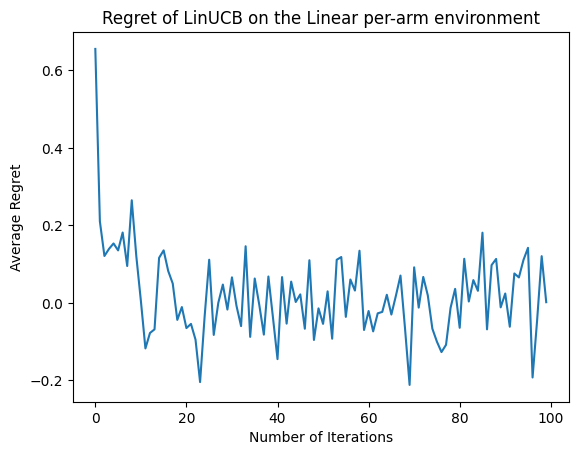

In [76]:
plt.plot(regret_values)
plt.title('Regret of LinUCB on the Linear per-arm environment')
plt.xlabel('Number of Iterations')
_ = plt.ylabel('Average Regret')

## Trainer loop

#### Vertex AI Experiments

In [57]:
EXPERIMENT_NAME   = f'perarm-linear-env-{PREFIX}'

# new experiment
invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

BASE_OUTPUT_DIR   = f'{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}'
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"       # Root directory for writing logs/summaries/checkpoints.
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME
)

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : perarm-linear-env-rec-bandits-v2
RUN_NAME          : run-20231024-154804

BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/perarm-linear-env-rec-bandits-v2/run-20231024-154804
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/perarm-linear-env-rec-bandits-v2/run-20231024-154804/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/perarm-linear-env-rec-bandits-v2/run-20231024-154804/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/perarm-linear-env-rec-bandits-v2/run-20231024-154804/artifacts


#### Define helper functions

In [58]:
from tf_agents.bandits.replay_buffers import bandit_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
# from tf_agents.google.metrics import export_utils
from tf_agents.metrics import export_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import policy_saver

In [59]:
def _get_replay_buffer(
    data_spec, batch_size, steps_per_loop, async_steps_per_loop
):
    """Return a `TFUniformReplayBuffer` for the given `agent`."""
    return bandit_replay_buffer.BanditReplayBuffer(
        data_spec=data_spec,
        batch_size=batch_size,
        max_length=steps_per_loop * async_steps_per_loop,
    )


def set_expected_shape(experience, num_steps):
    """Sets expected shape."""

    def set_time_dim(input_tensor, steps):
        tensor_shape = input_tensor.shape.as_list()
        if len(tensor_shape) < 2:
            raise ValueError(
                'input_tensor is expected to be of rank-2, but found otherwise: '
                f'input_tensor={input_tensor}, tensor_shape={tensor_shape}'
            )
        tensor_shape[1] = steps
        input_tensor.set_shape(tensor_shape)

    tf.nest.map_structure(lambda t: set_time_dim(t, num_steps), experience)

In [60]:
def _get_training_loop(
    driver, replay_buffer, agent, steps, async_steps_per_loop
):
    """Returns a `tf.function` that runs the driver and training loops.

    Args:
    driver: an instance of `Driver`.
    replay_buffer: an instance of `ReplayBuffer`.
    agent: an instance of `TFAgent`.
    steps: an integer indicating how many driver steps should be executed and
      presented to the trainer during each training loop.
    async_steps_per_loop: an integer. In each training loop, the driver runs
      this many times, and then the agent gets asynchronously trained over this
      many batches sampled from the replay buffer.
    """

    def _export_metrics_and_summaries(step, metrics):
        """Exports metrics and tf summaries."""
        metric_utils.log_metrics(metrics)
        export_utils.export_metrics(step=step, metrics=metrics)
        for metric in metrics:
            metric.tf_summaries(train_step=step)

    def training_loop(train_step, metrics):
        """Returns a function that runs a single training loop and logs metrics."""
        for batch_id in range(async_steps_per_loop):
            driver.run()
            _export_metrics_and_summaries(
                step=train_step * async_steps_per_loop + batch_id, metrics=metrics
            )
        batch_size = driver.env.batch_size
        dataset_it = iter(
            replay_buffer.as_dataset(
                sample_batch_size=batch_size,
                num_steps=steps,
                single_deterministic_pass=True,
            )
        )
        for batch_id in range(async_steps_per_loop):
            experience, unused_buffer_info = dataset_it.get_next()
            set_expected_shape(experience, steps)
            loss_info = agent.train(experience)
            export_utils.export_metrics(
                step=train_step * async_steps_per_loop + batch_id,
                metrics=[],
                loss_info=loss_info,
            )
            if train_step % 10 == 0:
                print(
                    f'step = {train_step}: train loss = {round(loss_info.loss.numpy(), 2)}'
                )

        replay_buffer.clear()

    return training_loop

In [61]:
AGENT_CHECKPOINT_NAME = 'agent'
STEP_CHECKPOINT_NAME = 'step'
CHECKPOINT_FILE_PREFIX = 'ckpt'

def restore_and_get_checkpoint_manager(root_dir, agent, metrics, step_metric):
    """Restores from `root_dir` and returns a function that writes checkpoints."""
    trackable_objects = {metric.name: metric for metric in metrics}
    trackable_objects[AGENT_CHECKPOINT_NAME] = agent
    trackable_objects[STEP_CHECKPOINT_NAME] = step_metric
    checkpoint = tf.train.Checkpoint(**trackable_objects)
    checkpoint_manager = tf.train.CheckpointManager(
        checkpoint=checkpoint, directory=root_dir, max_to_keep=5
    )
    latest = checkpoint_manager.latest_checkpoint
    if latest is not None:
        logging.info('Restoring checkpoint from %s.', latest)
        checkpoint.restore(latest)
        logging.info('Successfully restored to step %s.', step_metric.result())
    else:
        logging.info(
            'Did not find a pre-existing checkpoint. Starting from scratch.'
        )
    return checkpoint_manager

In [62]:
def train(
    # root_dir,
    artifact_dir,
    log_dir,
    agent,
    environment,
    training_loops,
    steps_per_loop,
    async_steps_per_loop=None,
    additional_metrics=(),
    get_replay_buffer_fn=None,
    get_training_loop_fn=None,
    training_data_spec_transformation_fn=None,
    save_policy=True,
    resume_training_loops=True,
):
    """Perform `training_loops` iterations of training.

    Checkpoint results.

    If one or more baseline_reward_fns are provided, the regret is computed
    against each one of them. Here is example baseline_reward_fn:

    def baseline_reward_fn(observation, per_action_reward_fns):
    rewards = ... # compute reward for each arm
    optimal_action_reward = ... # take the maximum reward
    return optimal_action_reward
    """

    # TODO(b/127641485): create evaluation loop with configurable metrics.
    if training_data_spec_transformation_fn is None:
        data_spec = agent.policy.trajectory_spec
    else:
        data_spec = training_data_spec_transformation_fn(
            agent.policy.trajectory_spec
        )
    if async_steps_per_loop is None:
        async_steps_per_loop = 1
    if get_replay_buffer_fn is None:
        get_replay_buffer_fn = _get_replay_buffer
    replay_buffer = get_replay_buffer_fn(
        data_spec, environment.batch_size, steps_per_loop, async_steps_per_loop
    )

    # `step_metric` records the number of individual rounds of bandit interaction;
    # that is, (number of trajectories) * batch_size.
    step_metric = tf_metrics.EnvironmentSteps()
    metrics = [
        tf_metrics.NumberOfEpisodes(),
        tf_metrics.AverageEpisodeLengthMetric(batch_size=environment.batch_size),
    ] + list(additional_metrics)

    # If the reward anything else than a single scalar, we're adding multimetric
    # average reward.
    if isinstance(
        environment.reward_spec(), dict
    ) or environment.reward_spec().shape != tf.TensorShape(()):
        metrics += [
            tf_metrics.AverageReturnMultiMetric(
                reward_spec=environment.reward_spec(),
                batch_size=environment.batch_size,
            )
        ]
    if not isinstance(environment.reward_spec(), dict):
        metrics += [
            tf_metrics.AverageReturnMetric(batch_size=environment.batch_size)
        ]

    if training_data_spec_transformation_fn is not None:
        add_batch_fn = lambda data: replay_buffer.add_batch(  # pylint: disable=g-long-lambda
        training_data_spec_transformation_fn(data)
    )
    else:
        add_batch_fn = replay_buffer.add_batch

    observers = [add_batch_fn, step_metric] + metrics

    driver = dynamic_step_driver.DynamicStepDriver(
        env=environment,
        policy=agent.collect_policy,
        num_steps=steps_per_loop * environment.batch_size,
        observers=observers,
    )

    if get_training_loop_fn is None:
        get_training_loop_fn = _get_training_loop
    training_loop = get_training_loop_fn(
        driver, replay_buffer, agent, steps_per_loop, async_steps_per_loop
    )
    checkpoint_manager = restore_and_get_checkpoint_manager(
        artifact_dir, agent, metrics, step_metric
    )
    train_step_counter = tf.compat.v1.train.get_or_create_global_step()
    if save_policy:
        saver = policy_saver.PolicySaver(
            agent.policy, train_step=train_step_counter
        )

    summary_writer = tf.summary.create_file_writer(log_dir)
    summary_writer.set_as_default()

    if resume_training_loops:
        train_step_count_per_loop = (
            steps_per_loop * environment.batch_size * async_steps_per_loop
        )
        last_checkpointed_step = step_metric.result().numpy()
        if last_checkpointed_step % train_step_count_per_loop != 0:
            raise ValueError(
                'Last checkpointed step is expected to be a multiple of '
                'steps_per_loop * batch_size * async_steps_per_loop, but found '
                f'otherwise: last checkpointed step: {last_checkpointed_step}, '
                f'steps_per_loop: {steps_per_loop}, batch_size: '
                f'{environment.batch_size}, async_steps_per_loop: '
                f'{async_steps_per_loop}'
            )
        starting_loop = last_checkpointed_step // train_step_count_per_loop
    else:
        starting_loop = 0

    for i in range(starting_loop, training_loops):
        training_loop(train_step=i, metrics=metrics)
        checkpoint_manager.save()
        if save_policy & (i % 100 == 0):
            saver.save(os.path.join(artifact_dir, 'policy_%d' % step_metric.result()))

In [63]:
TRAINING_LOOPS = 100
STEPS_PER_LOOP = 2

In [64]:
print(f"starting train loop...")
start_time = time.time()

train(
    # root_dir=BASE_OUTPUT_DIR,
      artifact_dir=ARTIFACTS_DIR,
      log_dir=LOG_DIR,
      agent=agent,
      environment=per_arm_tf_env,
      training_loops=TRAINING_LOOPS,
      steps_per_loop=STEPS_PER_LOOP,
      additional_metrics=[regret_metric, suboptimal_arms_metric],
      training_data_spec_transformation_fn=None,
)

runtime_mins = int((time.time() - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")

step = 0: train loss = 3.75
step = 10: train loss = 1.0399999618530273
step = 20: train loss = 1.0
step = 30: train loss = 1.2300000190734863
step = 40: train loss = 1.0
step = 50: train loss = 1.0399999618530273
step = 60: train loss = 1.0199999809265137
step = 70: train loss = 0.9399999976158142
step = 80: train loss = 0.9700000286102295
step = 90: train loss = 1.0399999618530273


### evlauate training job

In [65]:
# %load_ext tensorboard
%reload_ext tensorboard

In [66]:
%tensorboard --logdir=$LOG_DIR 